In [1]:
import numpy as np
import matplotlib.pyplot as plt
from camutils import Camera,triangulate,calibratePose,makerotation,decode,reconstruct,meshgeneration
import pickle
import visutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from skimage import transform
import cv2

%matplotlib notebook

Camera : 
 f=1404.6009661898656 
 c=[[962.16736847 590.91595678]] 
 R=[[ 0.03843674  0.98947411  0.13951199]
 [ 0.9773577  -0.00815434 -0.21143659]
 [-0.2080734   0.14448005 -0.96738357]] 
 t = [[ 6.86588545 19.52347156 47.34419117]] Camera : 
 f=1404.6009661898656 
 c=[[962.16736847 590.91595678]] 
 R=[[-0.00259871  0.99096865  0.13406855]
 [ 0.99277875 -0.01352251  0.11919521]
 [ 0.11993166  0.13341017 -0.98377748]] 
 t = [[ 7.50010607  7.20926295 47.76495312]]


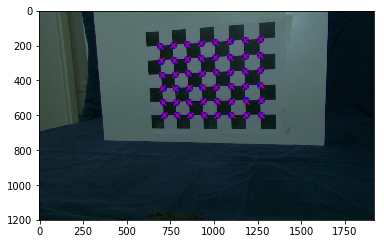

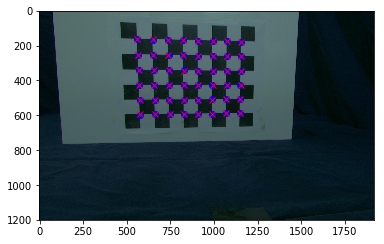

In [2]:
#calibrate to get the intrinsic and extrinsic parameters for the scanner cameras

# load in the intrinsic camera parameters from 'calibration.pickle'
file = open('calibration.pickle','rb') 
dict = pickle.load(file)
f=(dict['fx']+dict['fy'])/2
c=np.array([[dict['cx']],[dict['cy']]])
t=np.array([[0,0,0]]).T
R=makerotation(0,0,0)

# create Camera objects representing the left and right cameras 
# use the known intrinsic parameters you loaded in.
camL = Camera(f,c,R,t)
camR = Camera(f,c,R,t)

# load in the left and right images and find the coordinates of 
# the chessboard corners using OpenCV
imgL = plt.imread('/Users/minoxu/Desktop/117project/calib_jpg_u/frame_C0_01.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None) 
pts2L = cornersL.squeeze().T
imgR = plt.imread('/Users/minoxu/Desktop/117project/calib_jpg_u/frame_C1_01.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None) 
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6)) 
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)

#Now use the calibratePose function to get the extrinsic parameters
params_init_L=np.array([0,0,0,0,0,-2]) 
params_init_R=np.array([0,0,0,0,0,-2])

camL = calibratePose(pts3,pts2L,camL,params_init_L) 
camR = calibratePose(pts3,pts2R,camR,params_init_R)
print(camL,camR)

plt.figure()
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

plt.figure()
pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )



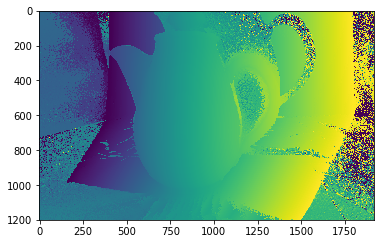

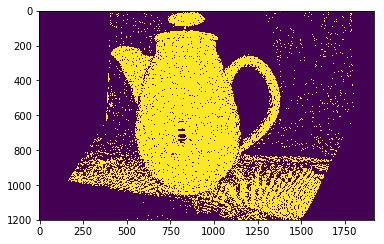

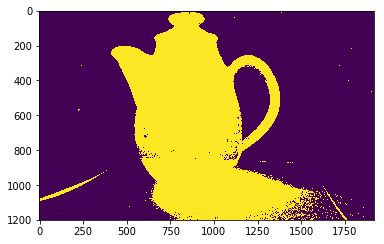

In [3]:
threshold1 = 0.006
threshold2 = 0.01
code,mask,color_mask = decode('/Users/minoxu/Desktop/117project/teapot/grab_0_u/color_C0_',\
                              '/Users/minoxu/Desktop/117project/teapot/grab_0_u/frame_C0_',0,threshold1,threshold2)

#display view code and mask as images
plt.figure() 
plt.imshow(code)
plt.figure() 
plt.imshow(mask)
plt.figure() 
plt.imshow(color_mask)

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



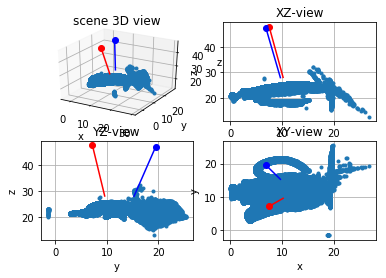

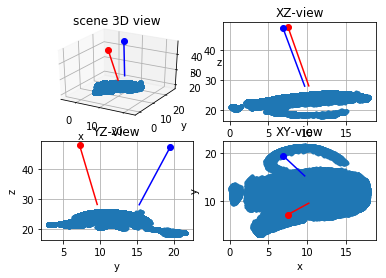

In [4]:
"""the intial recontrucion visulization without mesh clean"""

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/frame_C1_'

threshold1=0.006
threshold2=0.01

pts2L,pts2R,pts3,bvalues = \
reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)

visutils.vis_scene(camL,camR,pts3,looklength=20)

"""the recontrucion visulization with mesh clean"""

# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits
blim = np.array([-0.1,18,0,30,0,40])
trithresh=0.3

# drop points which are outside the bounding box
goodpts = np.nonzero((pts3[0,:]>blim[0])&(pts3[0,:]<blim[1]) & \
(pts3[1,:]>blim[2])&(pts3[1,:]<blim[3])& \
(pts3[2,:]>blim[4])&(pts3[2,:]<blim[5]))
                         
pts3 = pts3[:,goodpts[0]]
pts2L = pts2L[:,goodpts[0]]
pts2R = pts2R[:,goodpts[0]]
bvalues = bvalues[:,goodpts[0]]

#
# compute initial triangulation
from scipy.spatial import Delaunay
Triangles = Delaunay(pts2L.T)
tri = Triangles.simplices

#mesh smoothing
def find_neighbors(pindex, triang):
    return triang.vertex_neighbor_vertices[1]\
[triang.vertex_neighbor_vertices[0][pindex]:triang.vertex_neighbor_vertices[0][pindex+1]]

for x in range (pts3.shape[1]):
    pts3[:,x] = np.mean(pts3[:,find_neighbors(x,Triangles)],axis=1)

for x in range (pts3.shape[1]):
    pts3[:,x] = np.mean(pts3[:,find_neighbors(x,Triangles)],axis=1) 

for x in range (pts3.shape[1]):
    pts3[:,x] = np.mean(pts3[:,find_neighbors(x,Triangles)],axis=1) 
    
#
# triangle pruning
#
d01 = np.sqrt(np.sum(np.power(pts3[:,tri[:,0]]-pts3[:,tri[:,1]],2),axis=0))
d02 = np.sqrt(np.sum(np.power(pts3[:,tri[:,0]]-pts3[:,tri[:,2]],2),axis=0))
d12 = np.sqrt(np.sum(np.power(pts3[:,tri[:,1]]-pts3[:,tri[:,2]],2),axis=0))

goodtri = (d01<trithresh)&(d02<trithresh)&(d12<trithresh)
tri = tri[goodtri,:]

# remove any points which are not referenced in any triangle
#
#use np.unique applied to tri array to get a compact list of all vertices that are referenced:
tokeep=np.unique(tri)
map = np.zeros(pts3.shape[1])
pts3=pts3[:,tokeep]
bvalues = bvalues[:,tokeep]

#update tri
map[tokeep] = np.arange(0,tokeep.shape[0])
tri=map[tri]

visutils.vis_scene(camL,camR,pts3,looklength=20)

In [5]:
#call meshgeneration function to get .ply file for every grab

import meshutils

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_0_u/frame_C1_' 
threshold1=0.006
threshold2=0.01
pts2L,pts2R,pts3,bvalues = \
    reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)
blim=np.array([-0.1,18,0,30,0,40])
trithresh=0.3
pts3,tri,bvalues=meshgeneration(pts2L,pts2R,pts3,bvalues,imprefixL1,imprefixL2,imprefixR1,imprefixR2,\
                                blim,trithresh)
meshutils.writeply(pts3,bvalues,tri,'grab0.ply')

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_1_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_1_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_1_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_1_u/frame_C1_'
threshold1=0.006
threshold2=0.01
pts2L,pts2R,pts3,bvalues = \
    reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)
blim=np.array([-0.1,18,0,30,0,40])
trithresh=0.3
pts3,tri,bvalues=meshgeneration(pts2L,pts2R,pts3,bvalues,imprefixL1,imprefixL2,imprefixR1,imprefixR2,\
                                blim,trithresh)
meshutils.writeply(pts3,bvalues,tri,'grab1.ply')

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_2_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_2_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_2_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_2_u/frame_C1_'
threshold1=0.006
threshold2=0.01
pts2L,pts2R,pts3,bvalues = \
    reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)
blim=np.array([-0.1,18,0,30,0,40])
trithresh=0.5
pts3,tri,bvalues=meshgeneration(pts2L,pts2R,pts3,bvalues,imprefixL1,imprefixL2,imprefixR1,imprefixR2,\
                                blim,trithresh)
meshutils.writeply(pts3,bvalues,tri,'grab2.ply')

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_3_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_3_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_3_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_3_u/frame_C1_'
threshold1=0.006
threshold2=0.01
pts2L,pts2R,pts3,bvalues = \
    reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)
blim=np.array([-0.1,18,0,30,0,40])
trithresh=0.5
pts3,tri,bvalues=meshgeneration(pts2L,pts2R,pts3,bvalues,imprefixL1,imprefixL2,imprefixR1,imprefixR2,\
                                blim,trithresh)
meshutils.writeply(pts3,bvalues,tri,'grab3.ply')

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_4_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_4_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_4_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_4_u/frame_C1_'
threshold1=0.006
threshold2=0.01
pts2L,pts2R,pts3,bvalues = \
    reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)
blim=np.array([-0.1,18,0,30,0,40])
trithresh=0.3
pts3,tri,bvalues=meshgeneration(pts2L,pts2R,pts3,bvalues,imprefixL1,imprefixL2,imprefixR1,imprefixR2,\
                                blim,trithresh)
meshutils.writeply(pts3,bvalues,tri,'grab4.ply')

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_5_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_5_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_5_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_5_u/frame_C1_'
threshold1=0.006
threshold2=0.01
pts2L,pts2R,pts3,bvalues = \
    reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)
blim=np.array([-0.1,18,0,30,0,40])
trithresh=0.5
pts3,tri,bvalues=meshgeneration(pts2L,pts2R,pts3,bvalues,imprefixL1,imprefixL2,imprefixR1,imprefixR2,\
                                blim,trithresh)
meshutils.writeply(pts3,bvalues,tri,'grab5.ply')

imprefixL1 = '/Users/minoxu/Desktop/117project/teapot/grab_6_u/color_C0_'
imprefixL2 = '/Users/minoxu/Desktop/117project/teapot/grab_6_u/frame_C0_'
imprefixR1 = '/Users/minoxu/Desktop/117project/teapot/grab_6_u/color_C1_'
imprefixR2 = '/Users/minoxu/Desktop/117project/teapot/grab_6_u/frame_C1_'
threshold1=0.006
threshold2=0.01
pts2L,pts2R,pts3,bvalues = \
    reconstruct(imprefixL1,imprefixL2,imprefixR1,imprefixR2,threshold1,threshold2,camL,camR)
blim=np.array([-0.1,18,0,30,0,40])
trithresh=0.3
pts3,tri,bvalues=meshgeneration(pts2L,pts2R,pts3,bvalues,imprefixL1,imprefixL2,imprefixR1,imprefixR2,\
                                blim,trithresh)
meshutils.writeply(pts3,bvalues,tri,'grab6.ply')

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )